# ECES 681 - Computer Vision

## Homework 3

### Problem 1:



Print out training losses and train and val set
accuracy as it trains. After training concludes, also make a plot of the training losses as well as the training
and validation-set accuracy of the model during training.

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Load CIFAR-10 Dataset
Load CIFAR-10 dataset for image classification. This dataset consists of 32 × 32 RGB images of 10 different categories.

In [9]:
# Load the CIFAR10 dataset
transform = transforms.ToTensor()

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [40000, 10000],generator=generator)

# Dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, generator=generator)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define Network Architecture
This network has two FC layers with one ReLU activation layer: input -> FC layer -> ReLU layer -> FC
layer -> scores. Write two_layer_net.ipynb function


In [10]:
#  Define Network Architecture
class TwoLayerNet(nn.Module):
    """A two-layer fully connected neural network."""
    def __init__(self, input_dim=3072, hidden_dim=100, num_classes=10):
        """
        Args:
            input_dim (int): Size of the input vector (default 3072 for CIFAR-10).
            hidden_dim (int): Number of neurons in the hidden layer.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        # Fully connected layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # ReLU activated Layer
        self.relu = nn.ReLU()
        # Fully connected layer 2
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
         """
        Defines the forward pass through the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, 3, 32, 32)

        Returns:
            Tensor: Output scores of shape (batch_size, num_classes)
        """
        # Flatten the tensor
         x = x.view(x.size(0), -1)
         x = self.fc1(x)
         # Apply ReLU activation
         x = self.relu(x)
         return self.fc2(x)

In [11]:
# Define a function to handle calculating the accuracy and loss of the model
def evaluate_model(model, data_loader, criterion):
    """
    Evaluates the model's average loss and accuracy on a dataset.

    Args:
        model (nn.Module): The trained model to evaluate.
        data_loader (DataLoader): DataLoader for validation or test set.
        criterion (nn.Module): Loss function used (e.g., CrossEntropyLoss).

    Returns:
        tuple: (average_loss, accuracy) for the dataset
    """
    model.eval() # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient computation for speed
        for images, labels in data_loader: # Loop over validation or test data in batches
            outputs = model(images) # Perform forward pass through model for predicted scores
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1) #  Choose index of highest score for each sample (predicted class)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


### Train the Two-Layer Network with Loss and L2 Regularization
Initialize the two-layer network and the optimizer using stochastic gradient descent, implement a training loop for training.


The loss should be the sum of two terms:  
• A data loss term, which is the softmax loss between the model’s predicted scores and the ground-truth
image labels.  
• A regularization loss term, which penalizes the L2 norm of the weight matrices of all the fully-connected
layers of the model. You should not apply L2 regularization to the biases.

In [12]:
# Initialize the model, loss function, and optimizer
model = TwoLayerNet(input_dim=32*32*3, hidden_dim=256, num_classes=10)

learning_rate = 0.01
# weight_decay parameter in torch automatically applies L2 regularization
# to weights only
weight_decay = 0.0001

# Cross entropy loss deals with softmax loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# Training configuration
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Enable training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()             # Clear previous gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backpropagation
        optimizer.step()                  # Update weights

        # Accumulate training loss
        running_loss += loss.item() * images.size(0)

        # Compute training accuracy on the fly
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 2.0425, Train Acc: 0.2729 | Val Loss: 1.9077, Val Acc: 0.3409
Epoch 2/10 | Train Loss: 1.8696, Train Acc: 0.3436 | Val Loss: 1.8292, Val Acc: 0.3586
Epoch 3/10 | Train Loss: 1.8022, Train Acc: 0.3684 | Val Loss: 1.7732, Val Acc: 0.3734
Epoch 4/10 | Train Loss: 1.7519, Train Acc: 0.3860 | Val Loss: 1.7326, Val Acc: 0.3894
Epoch 5/10 | Train Loss: 1.7121, Train Acc: 0.4016 | Val Loss: 1.7027, Val Acc: 0.3997
Epoch 6/10 | Train Loss: 1.6761, Train Acc: 0.4153 | Val Loss: 1.6610, Val Acc: 0.4215
Epoch 7/10 | Train Loss: 1.6443, Train Acc: 0.4255 | Val Loss: 1.6464, Val Acc: 0.4248
Epoch 8/10 | Train Loss: 1.6187, Train Acc: 0.4344 | Val Loss: 1.6248, Val Acc: 0.4339
Epoch 9/10 | Train Loss: 1.5952, Train Acc: 0.4426 | Val Loss: 1.6018, Val Acc: 0.4376
Epoch 10/10 | Train Loss: 1.5753, Train Acc: 0.4504 | Val Loss: 1.5884, Val Acc: 0.4411


### Plot the Loss and Accuracy

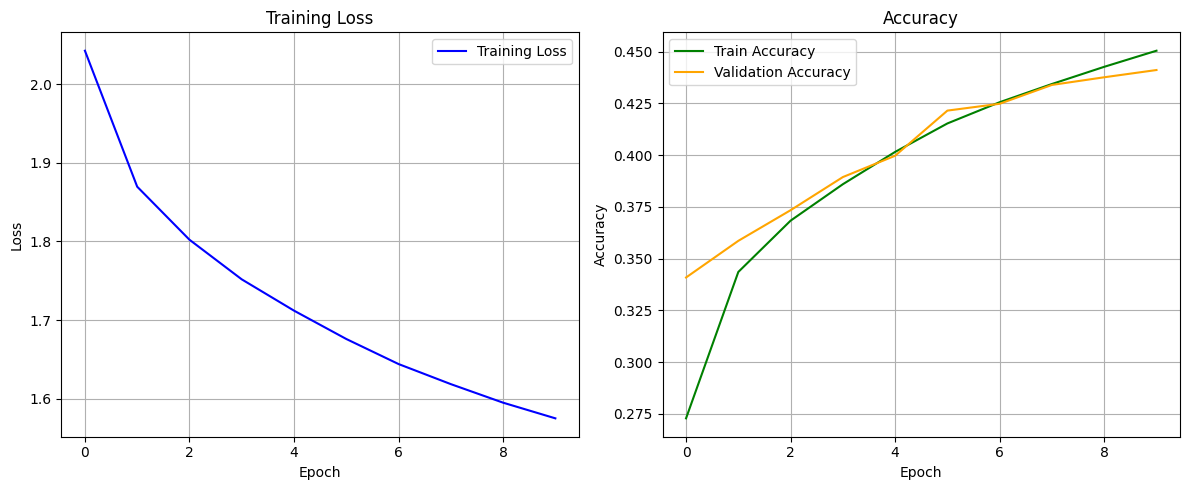

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Save best model weights

In [15]:
best_model_state = model.state_dict()  # Save a copy of model weights
torch.save(best_model_state, 'best_twonet_model.pth')  # Save to file



Best Model Hyperparameters:

Validation Accuracy: 44.11%

- num_train: 40,000 images
- hidden_dim: 256
- batch_size: 64
- num_epochs: 10  
- learning_rate: 0.01
- reg: 0.001

Final Test Accuracy

In [16]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"[TwoLayerNet] Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

[TwoLayerNet] Final Test Loss: 1.5800, Final Test Accuracy: 0.4465


### Problem 2:


In this assignment, you will design, implement, and train a two-layer Convolutional Neural Network
(CNN) followed by one fully connected (dense) layer at the end. Your goal is to improve the model's
performance using techniques learned in class.

Instructions:
1. Build the CNN Architecture

  - The network should consist of two convolutional layers followed by at least one fully
connected layer at the end.
  - You may use ReLU activation for non-linearity and max pooling to reduce spatial
dimensions.
  - Feel free to experiment with kernel sizes, strides, and padding to improve performance.
2. Enhance Model Performance

  - Implement any optimization techniques learned in class, such as:
    * Batch Normalization (for stable and faster training)
    * Dropout (to prevent overfitting)
    * Data Augmentation (to increase dataset diversity)
  - You may also experiment with different learning rates, optimizers, or regularization
techniques to achieve higher accuracy.

3. Train Your Model
  - Use the same dataset as in Problem 1.
  - Follow all the training steps and preprocessing mentioned in Problem 1.
  - Ensure proper train-validation splitting to evaluate the model correctly.
4. Evaluate Your Model

  - Report training and validation accuracy/loss using appropriate plots.
  - Report test accuracy/loss using using the best setting.
  - Compare your results with those from Problem 1.
  - Discuss how the addition of CNN layers and techniques like dropout or batch normalization affected performance.

#### Data Augmentation

To increase dataset diversity

In [77]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # Randomly flip image horizontally
    transforms.RandomCrop(32, padding=4),      # Randomly crop to 32x32 with 4-pixel padding
    transforms.ToTensor(),                     # Convert image to [0, 1] tensor
    transforms.Normalize((0.5, 0.5, 0.5),       # Normalize each channel to [-1, 1]
                         (0.5, 0.5, 0.5))
])

# Matching Normalization transformation for val and test sets
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [78]:
# Apply transforms to datasets
train_dataset = CIFAR10(root='./data', train=True, download=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split into training and validation sets (e.g., 45k train / 5k val)
train_set, val_set = random_split(train_dataset, [45000, 5000], generator=generator)

# Manually apply transforms to train_set and val_set transform
train_set.dataset.transform = transform_train
val_set.dataset.transform = transform_test

# Increased batch size and made chnages to use GPU resources for training
batch_size = 512

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [79]:
def evaluate_model(model, data_loader, criterion):
    """
    Evaluates model loss and accuracy on a dataset.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    device = next(model.parameters()).device  # Automatically detect if model is on CPU or GPU

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


#### Build CNN Architecture

- The network consists of two convolutional layers followed by at least one fully
connected layer at the end.
  - You may use ReLU activation for non-linearity and max pooling to reduce spatial
dimensions.
  - Feel free to experiment with kernel sizes, strides, and padding to improve performance.

 -  Implemented the following optimization techniques learned in class:
    * Batch Normalization (for stable and faster training)
    * Dropout (to prevent overfitting)
    * Data Augmentation (to increase dataset diversity)
  - You may also experiment with different learning rates, optimizers, or regularization
techniques to achieve higher accuracy.

In [80]:
class CNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for image classification on CIFAR-10.

    Architecture:
    - Two convolutional layers with ReLU activation and max pooling
    - Batch normalization after each convolution (optional)
    - One fully connected hidden layer with dropout
    - Output layer with logits for 10 classes
    """

    def __init__(self):
        """
        Initializes the CNN architecture.
        """
        super().__init__()

        # Convolutional layers block
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Conv Layer 1: input channels=3 (RGB), output=32
            nn.BatchNorm2d(32),                           # Normalize across batch
            nn.ReLU(),                                    # ReLU activation
            nn.MaxPool2d(2),                              # Downsample by factor of 2 (output: 16x16)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv Layer 2: input=32, output=64
            nn.BatchNorm2d(64),                           # Normalize
            nn.ReLU(),                                    # ReLU activation
            nn.MaxPool2d(2),                               # Downsample by factor of 2 (output: 8x8)


            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer 3: input=64, output=128
            nn.BatchNorm2d(128),                           # Normalize
            nn.ReLU(),                                    # ReLU activation
            nn.MaxPool2d(2)                               # Downsample by factor of 2 (output: 4x4)

        )

        # Fully connected layers block
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),                              # Dropout for regularization
            nn.Linear(128 * 4 * 4, 512),                   # Flattened input: 128 channels * 4x4 feature map
            nn.ReLU(),                                    # ReLU activation
            nn.Linear(512, 10)                            # Final output layer: 10 class scores
        )

    def forward(self, x):
        """
        Defines the forward pass of the CNN.

        Args:
            x (Tensor): Input image tensor of shape (batch_size, 3, 32, 32)

        Returns:
            Tensor: Output logits of shape (batch_size, 10)
        """
        x = self.conv_layers(x)                   # Pass through conv + pool block
        x = x.view(x.size(0), -1)                 # Flatten to (batch_size, 64*8*8) for fully connected layer
        return self.fc_layers(x)                  # Pass through fully connected layers


### Initialize Model and Train

In [88]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()  # Softmax + cross-entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

scaler = GradScaler('cuda')

Training Loop

In [89]:
num_epochs = 30

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda'): # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backpropagation with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Training stats
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation evaluation
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)


    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")




Epoch 1/30 | Train Loss: 1.5349, Train Acc: 0.4496 | Val Loss: 1.1094, Val Acc: 0.6038
Epoch 2/30 | Train Loss: 1.0845, Train Acc: 0.6115 | Val Loss: 0.9427, Val Acc: 0.6642
Epoch 3/30 | Train Loss: 0.9274, Train Acc: 0.6698 | Val Loss: 0.8664, Val Acc: 0.6970
Epoch 4/30 | Train Loss: 0.8470, Train Acc: 0.6996 | Val Loss: 0.8635, Val Acc: 0.7008
Epoch 5/30 | Train Loss: 0.7872, Train Acc: 0.7193 | Val Loss: 0.7279, Val Acc: 0.7444
Epoch 6/30 | Train Loss: 0.7337, Train Acc: 0.7395 | Val Loss: 0.7568, Val Acc: 0.7288
Epoch 7/30 | Train Loss: 0.6921, Train Acc: 0.7544 | Val Loss: 0.7009, Val Acc: 0.7566
Epoch 8/30 | Train Loss: 0.6492, Train Acc: 0.7698 | Val Loss: 0.6885, Val Acc: 0.7666
Epoch 9/30 | Train Loss: 0.6197, Train Acc: 0.7811 | Val Loss: 0.6432, Val Acc: 0.7752
Epoch 10/30 | Train Loss: 0.5979, Train Acc: 0.7877 | Val Loss: 0.6617, Val Acc: 0.7644
Epoch 11/30 | Train Loss: 0.5607, Train Acc: 0.8021 | Val Loss: 0.6877, Val Acc: 0.7686
Epoch 12/30 | Train Loss: 0.5374, Train A

Plot Training Loss and Training and Validation Accuracy

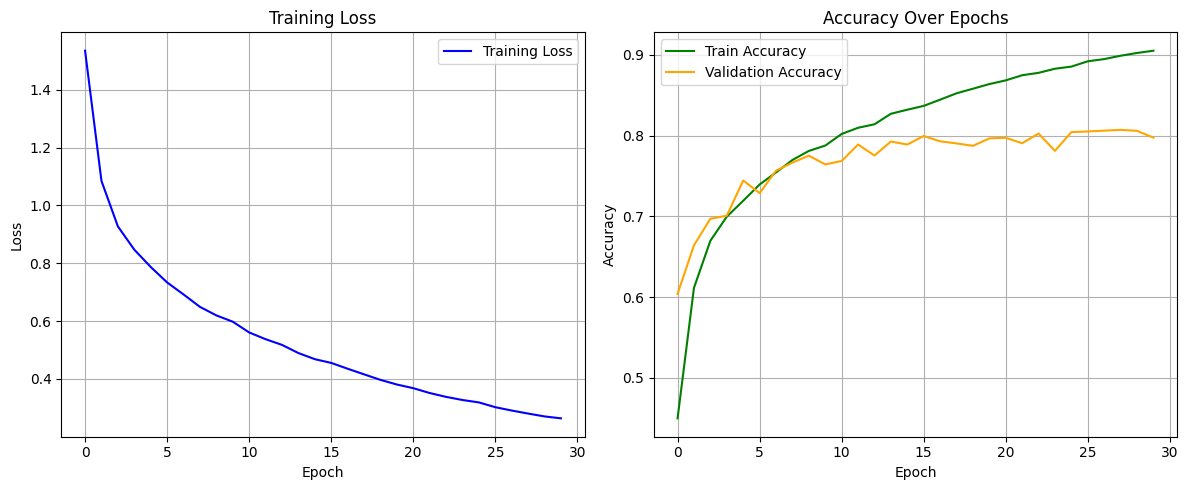

In [90]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()